In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import numpy as np
import numpy.linalg as la

def add_relative_to_current_source_file_path_to_sys_path(relpath):
    import os, sys, inspect
    path = os.path.realpath(os.path.abspath(os.path.join(os.path.split(inspect.getfile(inspect.currentframe()))[0],relpath)))
    if path not in sys.path:
        sys.path.insert(0,path)

add_relative_to_current_source_file_path_to_sys_path("../../shims/toric")   

import toric
import toric.samples
import toric.shims

In [3]:
a = toric.Vector3(1,2,3)
print a
print a.np()
t = toric.Toric3(toric.RadianPi(0.5),toric.Radian2Pi(0.5),toric.RadianPi(0.5))
print t

def slerp(p0, p1, t):
        omega = np.arccos(np.dot(p0/np.linalg.norm(p0), p1/np.linalg.norm(p1)))
        so = np.sin(omega)
        return np.sin((1.0-t)*omega) / so * p0 + np.sin(t*omega)/so * p1


(1.00, 2.00, 3.00)
[ 1.  2.  3.]
(a = 28.65°, t = 29°, p = 28.65°)


In [4]:
def drawSetup(fudgeX=2, fudgeY_pos=2,fudgeY_neg=8):
    pylab.rcParams['figure.figsize'] = 8, 8

    circle_PA_1=plt.Circle((PA_1.x(),PA_1.y()),min_dist,color='g',alpha=0.5)
    circle_PB_1=plt.Circle((PB_1.x(),PB_1.y()),min_dist,color='g',alpha=0.5)

    fig = plt.gcf()
    fig.gca().add_artist(circle_PA_1)
    fig.gca().add_artist(circle_PB_1)

    # Set up plot size
    plt.axes().set_xlim((np.min([PA_1.x(), PB_1.x()])-fudgeX,np.max([PA_1.x(), PB_1.x()])+fudgeX))
    plt.axes().set_ylim((np.min([PA_1.y(), PB_1.y()])-fudgeY_neg,np.max([PA_1.y(), PB_1.y()])+fudgeY_pos))

    # Draw People Positions
    plt.scatter([PA_1.x(), PB_1.x()],[PA_1.y(), PB_1.y()],c="red",linewidths=0)

    # Draw Circles
    
    plt.axes().set_aspect('equal')

    # Draw Camera positions
    plt.scatter([C_0.x(), C_1.x()],[C_0.y(), C_1.y()],c="blue",linewidths=0)

# Prove that our transition trajectories maintains minimum distance constraint to both subjects.

### Problem Setup:

Given two subjects $\vec{A}$ and $\vec{B}$ and a starting and ending camera position $\vec{C}_0$ and $\vec{C}_1$, calculate a path $\vec{\sigma}(u)$ where $\vec{\sigma}(0) = \vec{C}_0$ and $\vec{\sigma}(1) = \vec{C}_1$. All vectors are in world space $(x,y,z)$. 

$\vec{\sigma}(u)$ needs to satisfy two minimum distance constraints:

$$
\begin{align}
\|\vec{\sigma}(u) - \vec{A}\| && \leq && d_m \\
\|\vec{\sigma}(u) - \vec{B}\| && \leq && d_m
\end{align}
$$

We will calculate $\vec{\sigma}(u)$ as follows:

Consider the simplified interpolation space $(\vec{v}_A(u),\vec{v}_B(u),d_A(u),d_B(u))$ where $\vec{v}_i(u)$ is an interpolation function producting a unit "vantage" vector and $d_i(u)$ is a interpolation function producing a distance along the unit "vantage" vector. 

That is:

$$
\begin{align}
d_A(0) & = \|\vec{C}_0\ - \vec{A}\| \\
d_A(1) & = \|\vec{C}_1\ - \vec{A}\| \\
d_A(u) & = (1 - u)*d_A(0)  + u*d_A(1) \\
\vec{v}_A(0) & = \frac{\vec{C}_0 - \vec{A}}{\|\vec{C}_0 - \vec{A}\|} \\
\vec{v}_A(1) & = \frac{\vec{C}_1 - \vec{A}}{\|\vec{C}_1 - \vec{A}\|} \\
\vec{v}_A(u) & = SLERP(\vec{v}_i(0),\vec{v}_i(1); u)  
\end{align}
$$

and equivalent for $d_B$ and $\vec{v}_B$, where 

$$
u \in (0,1)
$$

### First Consider the Simplified Interpolation Function

We define $\vec{\sigma}(u)$ as

$$
\vec{\sigma}(u) = \frac{1}{2}[\vec{A} + \vec{B} + \sum_{i} d_i(u)\vec{v_i}(u)] \\
$$

Notice this is a simplified version of $F_{A,B}(x)$ presented in Lino et al

#### Prove that $\vec{\sigma}(u)$ maintains constraints under certain restrictions on $\vec{C}_0$ and $\vec{C}_1$

Manipulate $\vec{\sigma}(u)$:

$$
\vec{\sigma}(u) = \frac{\vec{\sigma}_A(u) + \vec{\sigma}_B(u)}{2}
$$

where

$$
\begin{align}
\vec{\sigma}_A(u) & = \vec{A} + d_A(u)\vec{v}_A(u) \\
\vec{\sigma}_B(u) & = \vec{B} + d_B(u)\vec{v}_B(u) \\
\end{align}
$$

That is, we consider separately interpolating the components of $\vec{\sigma}(u)$ relating to person $A$ and person $B$

#### Restriction: Consider the case where $\vec{C}_0$ and $\vec{C}_1$ are both on the same side of the line $AB$. 

This implies $\vec{v}_A(u) * normal(B-A)$ and $\vec{v}_B(u) * normal(B-A)$ have the same sign.


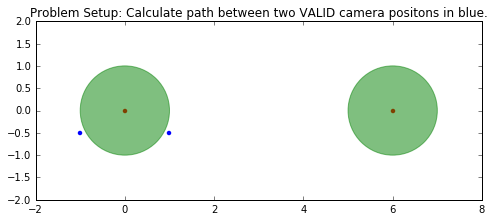

In [8]:
#
# Setting up a desired start and end camera position
#

min_dist = 1                    # let's set a minimum distance of 1m
PA_1 = toric.Vector3(0,0,0)     # person A position
PB_1 = toric.Vector3(6,0,0)     # person B position
C_0 = toric.Vector3(-1,-0.5,0)  # Starting camera position is *outside* of PA_1
C_1 = toric.Vector3( 1,-0.5,0)    # Ending camera position

drawSetup(fudgeY_neg=2)
plt.title("Problem Setup: Calculate path between two VALID camera positons in blue.")

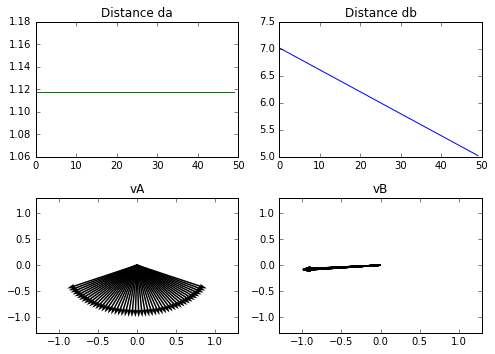

In [10]:

# Create Numpy arrays
A = PA_1.np()
B = PB_1.np()
C0 = C_0.np()
C1 = C_1.np()

# Set up interpolation vector
u = np.c_[np.linspace(0,1)]

# Set up the distance components of sigmaA, sigmaB
dA0 = la.norm(C0 - A)
dA1 = la.norm(C1 - A)
dB0 = la.norm(C0 - B)
dB1 = la.norm(C1 - B)

dA = np.linspace(dA0, dA1)
dB = np.linspace(dB0, dB1)

# Set up the vantage vector components of sigmaA, sigmaB
vA0 = (C0 - A) / dA0
vA1 = (C1 - A) / dA1
vB0 = (C0 - B) / dB0
vB1 = (C1 - B) / dB1

vA = np.apply_along_axis(lambda u : slerp(vA0,vA1,u), axis=1, arr=u)
vB = np.apply_along_axis(lambda u : slerp(vB0,vB1,u), axis=1, arr=u)

# Set up sigmaA, sigmaB, sigma
sigmaA = A + dA[:,np.newaxis] * vA
sigmaB = B + dB[:,np.newaxis] * vB
sigma = (sigmaA + sigmaB) / 2

#
# Graphing the various components of Sigma
#
from matplotlib import gridspec
gs = gridspec.GridSpec(2, 2, width_ratios=[1,1], height_ratios=[1,1,1]) 
fig = plt.figure()

f1 = fig.add_subplot(gs[0])
f2 = fig.add_subplot(gs[1])
f3 = fig.add_subplot(gs[2])
f4 = fig.add_subplot(gs[3])

f1.plot(dA,c="green")
f1.set_title("Distance da")
f2.plot(dB,c="blue")
f2.set_title("Distance db")

f3.quiver(np.linspace(0,0), np.linspace(0,0), vA[:,0],vA[:,1],angles='xy',scale_units='xy',scale=1)
f3.set_ylim([-1.3,1.3])
f3.set_xlim([-1.3,1.3])
f3.set_title("vA")

f4.quiver(np.linspace(0,0), np.linspace(0,0), vB[:,0],vB[:,1],angles='xy',scale_units='xy',scale=1)
f4.set_ylim([-1.3,1.3])
f4.set_xlim([-1.3,1.3])
f4.set_title("vB")

## Counterexample!

Given a valid start and end camera positions, both on the same side of the line AB, our simplified $\vec{\sigma}(u)$ *doesn't work*.

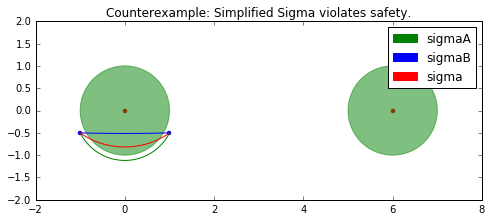

In [11]:

drawSetup(fudgeY_neg=2)
plt.plot(sigmaA[:,0],sigmaA[:,1], c="green")
plt.plot(sigmaB[:,0],sigmaB[:,1], c="blue")
plt.plot(sigma[:,0], sigma[:,1],  c="red")
plt.title("Counterexample: Simplified Sigma violates safety.")

sA_legend = mpatches.Patch(color="green", label="sigmaA")
sB_legend = mpatches.Patch(color="blue", label="sigmaB")
S_legend  = mpatches.Patch(color="red", label="sigma")
plt.legend(handles=[sA_legend,sB_legend,S_legend])
